# **Heart rate estimation project**
### by Erica Brisigotti, Ekaterina Chueva, Maximilian Peter, Nadillia Saphutra

## 0. **Introduction**
[THIS PART MUST BE CHANGED AND INTEGRATED WITH DETAILS ABOUT HEART RATE AND CYCLE, SCG AND BCG, AND WITH ALL THE THEORETICAL INFO THAT WE'RE USING TO MAKE INFORMED DECISIONS LATER IN THE ANALYSIS PART]

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import scipy.linalg as la

## 1. **Data preparation**

### 1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

Even before uploading the data, it is well-known that there are 16 columns with different meanings. Specifically:
* **Log Freq** stands for the acquisition  in Hz (i.e., sampling interval is constant).
* **AccX, AccY, AccZ** are the measured magnitude of linear acceleration along each axis.
* **GyroX, GyroY, GyroZ** are the measured magnitude of angular velocity along each axis.
* **MagnX, MagnY, MagnZ** are the measured magnitude of magnetic field along each axis.
* **qw, qi, qj, qk** are the quaternion components, representing the spatial orientation of the Muse system.

Further *a priori* information follows from the theoretical information (previously explained in the introduction) about the techniques to be implemented: SCG and BCG. Both of these strategies analyse the evolution in time of accelleration and angular momentum. Therere, only accelerometer, gyrometer and time measurements will be needed.

The other physical quantities can be discarded.

Such statements are supported by the data, which is uploaded (as a Pandas' dataframe) and statistically analyzed through the appropriate Pandas' built-in function (<code>pandas.describe</code>).

In [2]:
file_name = 'center_sternum.txt'
just_uploaded = pd.read_csv(file_name, delimiter='\t')
all_data = pd.DataFrame(just_uploaded)
display(all_data)
all_data.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,16506.0,16506.0,1.650600e+04,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,5.0,200.0,1.576223e+09,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005,0.063803,0.490530,-0.764329,-0.039947
std,0.0,0.0,2.189258e+01,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453,0.144073,0.197328,0.326346,0.057694
min,5.0,200.0,1.576223e+09,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000,0.004428,-0.622059,-0.892911,-0.096347
25%,5.0,200.0,1.576223e+09,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000,0.021518,0.493858,-0.859676,-0.060732
50%,5.0,200.0,1.576223e+09,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000,0.024636,0.529649,-0.836619,-0.059511
75%,5.0,200.0,1.576223e+09,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000,0.027304,0.564768,-0.813227,-0.057619
max,5.0,200.0,1.576223e+09,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000,0.792622,0.624806,0.921293,0.251900


In [3]:
# timestamp have repetitive values that may represent a meaningful division of the data, but there's no info that supports it

The brief descriptive statistics provided by the <code>pandas.describe</code> function are particularly helpful in getting the time at which every measurement has been taken.
The **Log Freq** data, which represents the acquisition rate (in Hz), is constant and therefore allows for straigh-forward identification of the time interval between two successive measurements:

In [4]:
freq = all_data['Log Freq'].unique()[0] # Hz
time = np.arange(0,(len(all_data.index)/freq),(1/freq)) # seconds

Furthermore, the units of measurement for acceleration (mg, i.e. milli-g) and angular velocity (dps, i.e. degrees per second) are found in the calibration file (**README1.txt**).
$$ w[rad/s] = \frac{w[dps]*200}{2^{15}}*\frac{\pi}{180} $$


All unnecessary columns can now be dropped and a new one can be added to store the corresponding values of time.

In [5]:
data = all_data.drop(['MagnX','MagnY','MagnZ','qw','qi','qj','qk','Log Mode','Log Freq','Timestamp'], axis = 1)
data.insert(0, "Time", time)
data #.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
1,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
2,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
3,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
4,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
...,...,...,...,...,...,...,...
16501,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756
16502,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290
16503,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763
16504,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786


We can now finally use the information given by the calibration (contained in 'README1' for the "center_sternum" file), at least the more obvious ones given by the offset of the accelerometer.

In [6]:
gyro_calibration = np.array( [ -2.242224 , 2.963463	, -0.718397 ] )
acc_offsets = np.array( [ -3.929942 , -13.7467 , 60.67546 ] )
acc_calibration = np.array( [ [1.000966 , -0.002326418 , -0.0006995499 ] , [ -0.002326379 , 0.9787045 , -0.001540918 ] , 
                              [-0.0006995811 , -0.001540928 , 1.00403 ] ] ).T
#data[ ['AccX','AccY','AccZ'] ] = data[ ['AccX','AccY','AccZ'] ].dot(acc_calibration)
data['AccX'] += acc_offsets[0]
data['AccY'] += acc_offsets[1]
data['AccZ'] += acc_offsets[2]
#data['GyroX'] = gyro_calibration[0]*data['GyroX']
#data['GyroY'] = gyro_calibration[1]*data['GyroY']
#data['GyroZ'] = gyro_calibration[2]*data['GyroZ']

data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,41.262500,31.673810,108.007722,-836.326005,-1.885665,3.636535,-0.818354
std,23.825081,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643
min,0.000000,-726.047942,-401.584700,-1671.297540,-359.496200,-213.557300,-126.351100
25%,20.631250,-39.187942,97.273300,-897.634540,-2.839695,3.206107,-1.175573
50%,41.262500,-33.514942,102.153300,-888.057540,-2.137405,3.664122,-0.854962
75%,61.893750,-26.621942,106.728300,-877.016540,-1.206107,4.213740,-0.549618
max,82.525000,1224.671058,990.862300,3147.675460,381.160300,349.816800,187.603100


### 1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

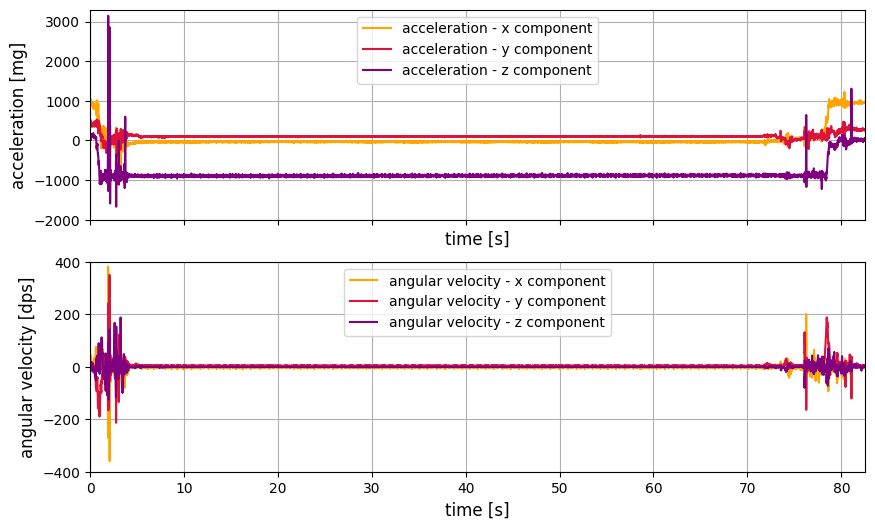

In [7]:
fig1,ax1 = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(12,8))

ax1[0].plot( data['Time'] , data['AccX'] , '-' , label='acceleration - x component',color='orange')
ax1[0].plot( data['Time'] , data['AccY'] , '-' , label='acceleration - y component',color='crimson')
ax1[0].plot( data['Time'] , data['AccZ'] , '-' , label='acceleration - z component',color='purple')
ax1[0].set_xlim( 0 , data['Time'].max() )
ax1[0].set_ylim( -2000 , 3300 )
ax1[0].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[0].set_ylabel( 'acceleration [mg]' , fontsize = 12 )
ax1[0].legend( loc='upper center' , fontsize = 10 )
ax1[0].grid()

ax1[1].plot( data['Time'] , data['GyroX'] , '-' , label = 'angular velocity - x component' , color='orange' )
ax1[1].plot( data['Time'] , data['GyroY'] , '-' , label = 'angular velocity - y component' , color='crimson' )
ax1[1].plot( data['Time'] , data['GyroZ'] , '-' , label = 'angular velocity - z component' , color='purple' )
ax1[1].set_xlim( 0 , data['Time'].max() )
ax1[1].set_ylim( -400 , 400 )
ax1[1].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[1].set_ylabel( 'angular velocity [dps]' , fontsize = 12 )
ax1[1].legend( loc='upper center' , fontsize = 10 )
ax1[1].grid()


A few observations come up from a graphical representation of the remaining data:
- all measurements follow a similar trend, which consists of small obscillations around an offset for the majority of time and some larger fluctuations at the beginning and end
- supposing that the larger fluctuations were caused by the heartbeat, it follows that the patient's heart doesn't beat for over a minute (i.e. is dead) which is paradoxical: it follows that the interesting, heart-related information will be contained in the innermost, small obscillating portion of each set of measurement
- the larger fluctuations at the beginning and at the end of each measurement set are therefore regarded as anomalies (i.e. to be discarded), possibly due to the patient positioning himself or the devices being set up for the measurements

A quantitative approach to the selection of the data to be kept is explained below. The algorithm starts from the center of the dataset to take increasingly wider subsets and calculate the corresponding standard deviation.
The selection is later made based on the evolution of standard deviation 

In [8]:
def std_from_center( vect ):
    vect = np.array( vect )
    center_idx = int( vect.shape[0]/2 )
    std_down = [ np.std(vect[ (center_idx-idx):center_idx ] ) for idx in range(1,center_idx,1) ] 
    std_up = [ np.std( vect[ center_idx:(center_idx+idx) ] ) for idx in range(1,center_idx,1) ] 
    return np.concatenate((std_down[::-1],std_up))

8253
the percentage of measurements to be kept is  78.75923906458257


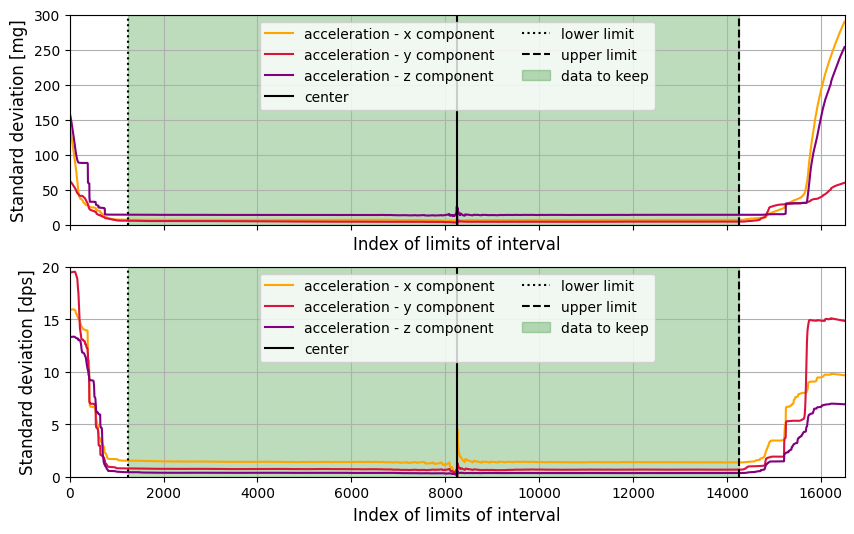

In [9]:
fig2,ax2 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = (12,8) )
center_idx = int( data.shape[0]/2 )
down_cut = 7000
up_cut = 6000
print( center_idx )
print('the percentage of measurements to be kept is ', (down_cut+up_cut)/data.shape[0]*100)
down_idx = center_idx-down_cut
up_idx = center_idx+up_cut
down_limit = ( data['Time'] )[ down_idx ]
up_limit =( data['Time'] )[ up_idx ]

ax2[0].plot( std_from_center( data['AccX']) , '-' , label = 'acceleration - x component' , color='orange' )
ax2[0].plot( std_from_center( data['AccY']) , '-' , label = 'acceleration - y component' , color='crimson' )
ax2[0].plot( std_from_center( data['AccZ']) , '-' , label = 'acceleration - z component' , color='purple' )
ax2[0].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' )
ax2[0].axvline( x = down_idx , linestyle = ':' , color = 'k' , label = 'lower limit' )
ax2[0].axvline( x = up_idx , linestyle = '--' , color = 'k' , label = 'upper limit' )
ax2[0].fill_betweenx( y = [0,300] , x1 = down_idx , x2 = up_idx , color='forestgreen' , alpha =0.3 , label = 'data to keep')
ax2[0].set_xlim( 0 , data.shape[0] )
ax2[0].set_ylim( 0 , 300 )
ax2[0].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[0].set_ylabel( 'Standard deviation [mg]' , fontsize = 12 )
ax2[0].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax2[0].grid()

ax2[1].plot( std_from_center( data['GyroX']) , '-' , label = 'acceleration - x component' , color='orange' )
ax2[1].plot( std_from_center( data['GyroY']) , '-' , label = 'acceleration - y component' , color='crimson' )
ax2[1].plot( std_from_center( data['GyroZ']) , '-' , label = 'acceleration - z component' , color='purple' )
ax2[1].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' )
ax2[1].axvline( x = down_idx , linestyle = ':' , color = 'k' , label = 'lower limit' )
ax2[1].axvline( x = up_idx , linestyle = '--' , color = 'k' , label = 'upper limit' )
ax2[1].fill_betweenx( y = [0,20] , x1 = down_idx, x2 = up_idx , color='forestgreen' , alpha = 0.3 , label='data to keep' )
ax2[1].set_xlim( 0 , data.shape[0] )
ax2[1].set_ylim( 0 , 20 )
ax2[1].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[1].set_ylabel( 'Standard deviation [dps]' , fontsize = 12 )
ax2[1].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax2[1].grid()

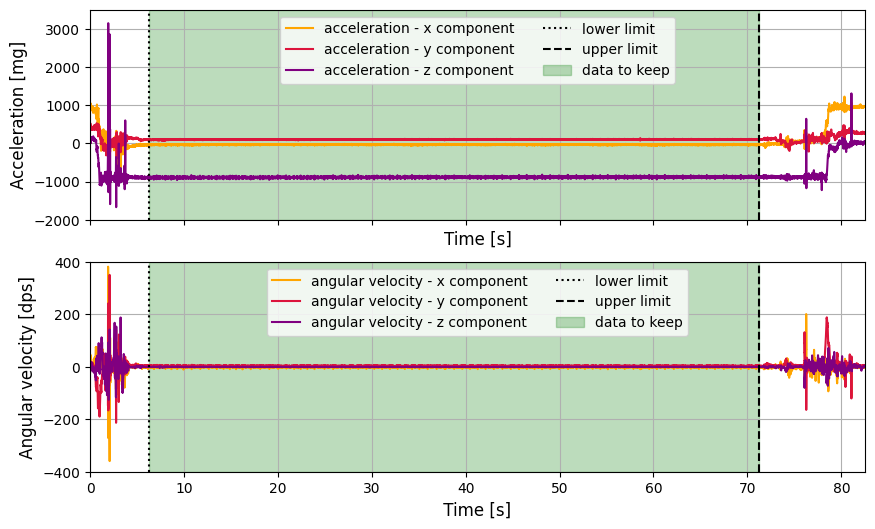

In [10]:
fig3, ax3 = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(12,8))

ax3[0].plot( data['Time'] , data['AccX'] , '-' , label = 'acceleration - x component' , color = 'orange' )
ax3[0].plot( data['Time'] , data['AccY'] , '-' , label = 'acceleration - y component' , color = 'crimson' )
ax3[0].plot( data['Time'] , data['AccZ'] , '-' , label = 'acceleration - z component' , color = 'purple' )
ax3[0].axvline( x = down_limit , linestyle = ':' , color = 'k' , label = 'lower limit' )
ax3[0].axvline( x = up_limit , linestyle = '--' , color = 'k' , label = 'upper limit' )
ax3[0].fill_betweenx( y = [-2000,+3500] , x1 = down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[0].set_xlim( min(data['Time']) , max(data['Time']) )
ax3[0].set_ylim( -2000 , +3500 )
ax3[0].set_xlabel( 'Time [s]' , fontsize = 12 )
ax3[0].set_ylabel( 'Acceleration [mg]' , fontsize = 12 )
ax3[0].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax3[0].grid()

ax3[1].plot( data['Time'] , data['GyroX'] , '-' , label = 'angular velocity - x component' , color='orange' )
ax3[1].plot( data['Time'] , data['GyroY'] , '-' , label = 'angular velocity - y component' , color='crimson' )
ax3[1].plot( data['Time'] , data['GyroZ'] , '-' , label = 'angular velocity - z component' , color='purple' )
ax3[1].axvline( down_limit , linestyle = ':' , color = 'k' , label = 'lower limit' )
ax3[1].axvline( up_limit , linestyle = '--' , color = 'k' , label = 'upper limit' )
ax3[1].fill_betweenx( y=[ -400 , +400 ] , x1=down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[1].set_xlim( min( data['Time'] ) , max( data['Time'] ) )
ax3[1].set_ylim( -400, +400 )
ax3[1].set_xlabel( ' Time [s] ' , fontsize=12 )
ax3[1].set_ylabel( ' Angular velocity [dps] ' , fontsize=12 )
ax3[1].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax3[1].grid()

In [11]:
ok_data = data.copy()
ok_data.drop( data[ data['Time'] <= down_limit ].index, inplace=True)
ok_data.drop( data[ data['Time'] >= up_limit ].index, inplace=True)
ok_data.set_index(np.arange(len(ok_data)),inplace=True)

### 1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

#### PCA on acceleration

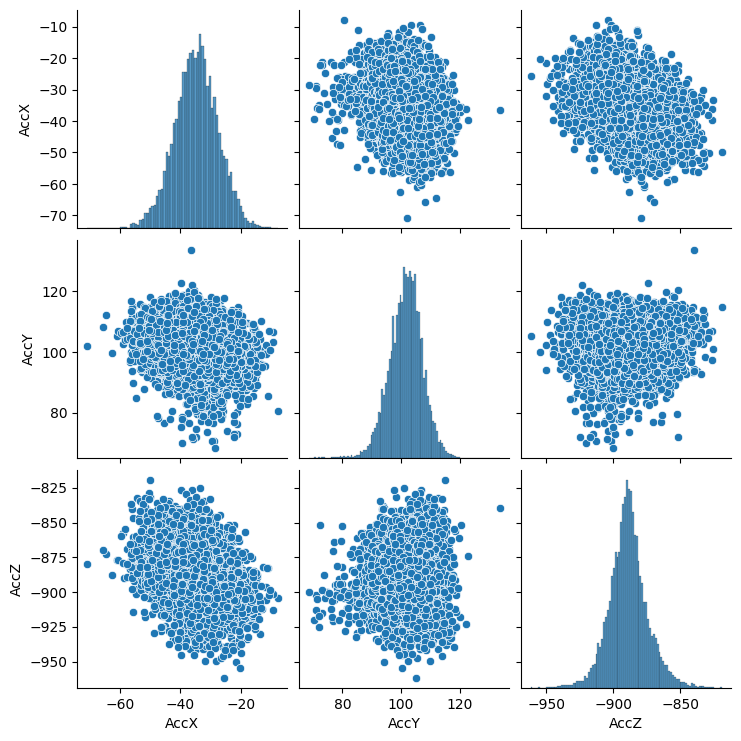

In [12]:
acc = ok_data[ ['AccX','AccY','AccZ'] ]
sns.pairplot(acc)

In [13]:
acc_cov = np.cov( acc.T )
acc_val , acc_vect = la.eig( acc_cov )
acc_val = np.real_if_close( acc_val )
print( 'the percentages corresponding the components of the acceleration are ' , acc_val*100/acc_val.sum() )

the percentages corresponding the components of the acceleration are  [76.01651084 13.89802654 10.08546262]


#### PCA on angular velocity

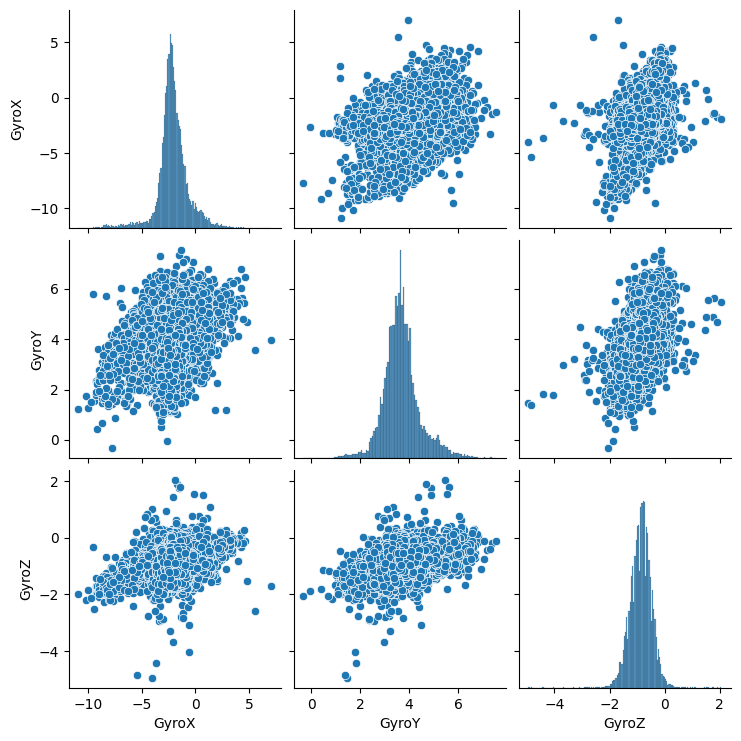

In [14]:
gyro = ok_data[ ['GyroX','GyroY','GyroZ'] ]
sns.pairplot( gyro )

In [15]:
gyro_cov = np.cov( gyro.T )
gyro_val , gyro_vct = la.eig( gyro_cov )
gyro_val = np.real_if_close( gyro_val )
print( 'the percentages corresponding the components of the acceleration are ' , gyro_val*100/gyro_val.sum() )

the percentages corresponding the components of the acceleration are  [79.8902901  15.99083415  4.11887575]


#### Combining the components together

None of the components can be discarded since all the corresponding percentages are non-negligible. On the other hand, they can be combined into a single variable to smoothen future analysis. 

The simplest approach consists of switching from a Carthesian to a polar set of coordinates

$$ \vec{v} \rightarrow \left(\,  x \, , \, y \, , \, z \, \right) \rightarrow \left(\,  \| \vec{v} \| \, , \, \theta \, , \, \phi \, \right) \;\;\; \text{where} \;\;\; \| \vec{v} \| = \sqrt{x^2 + y^2 + z^2} $$

and consider the norm $\| \vec{v} \|$ of the physical quantity $\vec{v}$. 

There is no need to switch to the eigenvector basis (from PCA) before calculating the norm $\| \vec{v} \|$ since it is invariant under rotations of the plane around the origin.

In [16]:
acc_norm = np.array(np.sqrt(ok_data['AccX']**2 + ok_data['AccY']**2 + ok_data['AccZ']**2))
gyro_norm = np.array(np.sqrt(ok_data['GyroX']**2 + ok_data['GyroY']**2 + ok_data['GyroZ']**2))
to_analyze =pd.DataFrame({ 'Time': ok_data['Time'] , 'Acc': acc_norm , 'Gyro': gyro_norm })
to_analyze

,Time,Acc,Gyro
0,6.270,899.596773,4.611698
1,6.275,918.636760,3.949037
2,6.280,909.235971,4.087072
3,6.285,917.118329,3.647641
4,6.290,903.030882,3.882098
...,...,...,...
12994,71.240,903.135695,3.897438
12995,71.245,887.301711,3.259426
12996,71.250,856.898104,3.905712
12997,71.255,883.382613,3.650547


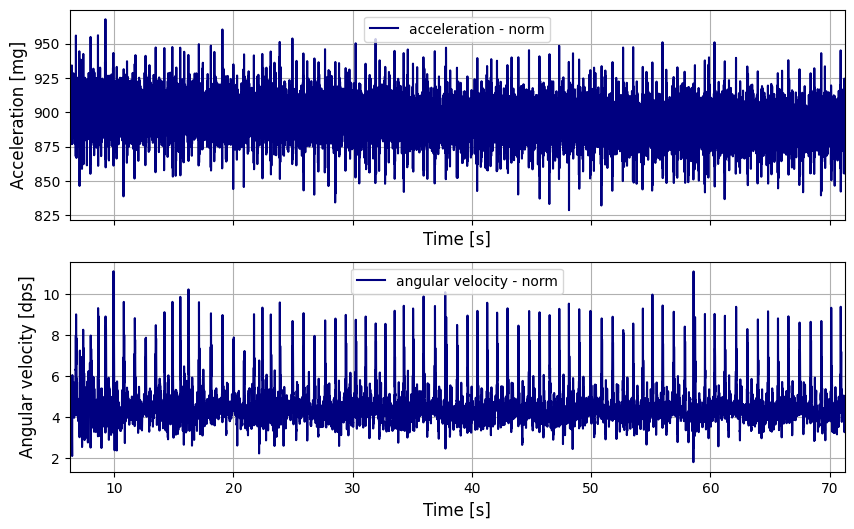

In [17]:
fig4, ax4 = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(12,8))

#ax4[0].plot( ok_data['Time'] , ok_data['AccX'] , '-' , label = 'acceleration - x component' , color = 'orange' )
#ax4[0].plot( ok_data['Time'] , ok_data['AccY'] , '-' , label = 'acceleration - y component' , color = 'crimson' )
#ax4[0].plot( ok_data['Time'] , ok_data['AccZ'] , '-' , label = 'acceleration - z component' , color = 'purple' )
ax4[0].plot( to_analyze['Time'] , to_analyze['Acc'] , '-' , label = 'acceleration - norm' , color = 'navy' )
ax4[0].set_xlim( min(ok_data['Time']) , max(ok_data['Time']) )
#ax4[0].set_ylim( -1000 , +1000 )
ax4[0].set_xlabel( 'Time [s]' , fontsize = 12 )
ax4[0].set_ylabel( 'Acceleration [mg]' , fontsize = 12 )
ax4[0].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax4[0].grid()

#ax4[1].plot( ok_data['Time'] , ok_data['GyroX'] , '-' , label = 'angular velocity - x component' , color='orange' )
#ax4[1].plot( ok_data['Time'] , ok_data['GyroY'] , '-' , label = 'angular velocity - y component' , color='crimson' )
#ax4[1].plot( ok_data['Time'] , ok_data['GyroZ'] , '-' , label = 'angular velocity - z component' , color='purple' )
ax4[1].plot( to_analyze['Time'] , to_analyze['Gyro'] , '-' , label = 'angular velocity - norm' , color = 'navy' )
ax4[1].set_xlim( min(ok_data['Time']) , max(ok_data['Time']) )
#ax4[1].set_ylim( -15 , +15 )
ax4[1].set_xlabel( 'Time [s]' , fontsize = 12 )
ax4[1].set_ylabel( 'Angular velocity [dps]' , fontsize = 12 )
ax4[1].legend( loc = 'upper center' , ncol = 2 , fontsize = 10 )
ax4[1].grid()


## 2. Time and frequency analysis:

### 2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [18]:
std_description = pd.concat( [ to_analyze.describe() , pd.DataFrame(to_analyze.median(),columns=['median']).transpose() , 
                                pd.DataFrame(to_analyze.var(),columns=['variance']).transpose() ] )
std_description

,Time,Acc,Gyro
count,12999.000000,12999.000000,12999.000000
mean,38.765000,895.236838,4.553518
std,18.763162,14.302321,0.869925
min,6.270000,828.592141,1.791276
25%,22.517500,887.486130,4.088669
50%,38.765000,895.585761,4.395913
75%,55.012500,903.642817,4.754445
max,71.260000,967.760031,11.133847
median,38.765000,895.585761,4.395913
variance,352.056250,204.556386,0.756769


In [19]:
to_analyze.corr()

,Time,Acc,Gyro
Time,1.000000,-0.255256,-0.059663
Acc,-0.255256,1.000000,-0.132380
Gyro,-0.059663,-0.132380,1.000000


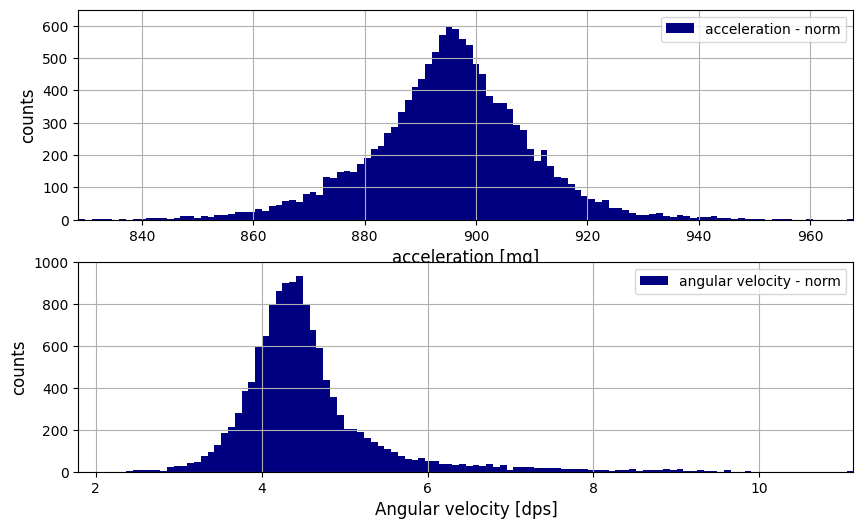

In [25]:
fig5, ax5 = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

ax5[0].hist( to_analyze['Acc'] , bins = int( np.sqrt(to_analyze['Acc'].shape[0] ) ) , label = 'acceleration - norm' , color = 'navy' )
ax5[0].set_xlim( min(to_analyze['Acc']) , max(to_analyze['Acc']) )
ax5[0].set_ylim( 0 , +650 )
ax5[0].set_xlabel( 'acceleration [mg]' , fontsize = 12 )
ax5[0].set_ylabel( 'counts' , fontsize = 12 )
ax5[0].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax5[0].grid()

ax5[1].hist( to_analyze['Gyro'] , bins = int( np.sqrt(to_analyze['Gyro'].shape[0] ) ) , label = 'angular velocity - norm' , color = 'navy' )
ax5[1].set_xlim( min( to_analyze['Gyro'] ) , max( to_analyze['Gyro'] ) )
ax5[1].set_ylim( 0 , 1000 )
ax5[1].set_xlabel( 'Angular velocity [dps]' , fontsize = 12 )
ax5[1].set_ylabel( 'counts' , fontsize = 12 )
ax5[1].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax5[1].grid()

plt.show()

## 3. Fourier Analysis: FFT and band-pass filter

Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 

In [39]:
# The FFT of the signal Z around the area of heart beat frequencies
acc_fft = fftpack.fft( acc_norm )
gyro_fft = fftpack.fft( gyro_norm )
# And the power (sig_fft is of complex dtype)
acc_power = np.abs( acc_fft )
gyro_power = np.abs( gyro_fft )

timestep = 1/freq
# The corresponding frequencies
acc_all_freq = fftpack.fftfreq( acc_norm.size, d = timestep )
gyro_all_freq = fftpack.fftfreq( gyro_norm.size, d = timestep )

In [40]:
down_freq_lim = 40/60 # Hz
up_freq_lim = 100/60 # Hz

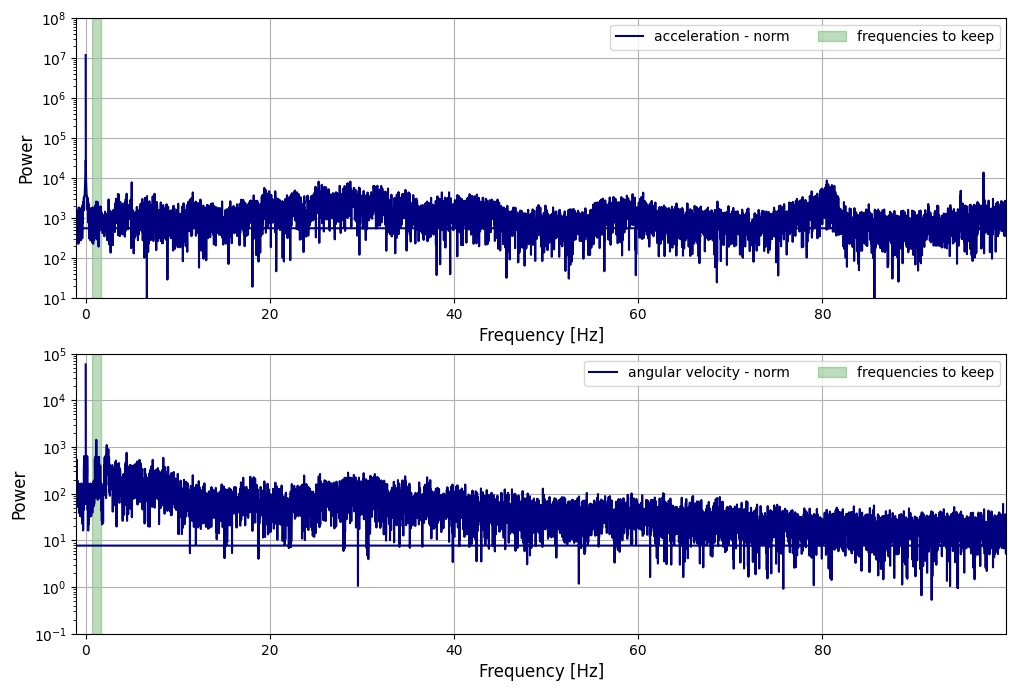

In [63]:
fig6, ax6 = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

ax6[0].plot( acc_all_freq , acc_power , '-' , label = 'acceleration - norm' , color = 'navy' )
ax6[0].fill_betweenx( y=[ 10**1 , 10**8 ] , x1=down_freq_lim , x2 = up_freq_lim , color='forestgreen' , alpha =0.3 , label = 'frequencies to keep' )
ax6[0].set_xlim( -1 , max(acc_all_freq) )
ax6[0].set_ylim( 10**1 , 10**8 )
ax6[0].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax6[0].set_ylabel( 'Power' , fontsize = 12 )
ax6[0].set_yscale('log')
ax6[0].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax6[0].grid()

ax6[1].plot( gyro_all_freq , gyro_power , '-' , label = 'angular velocity - norm' , color = 'navy' )
ax6[1].fill_betweenx( y=[ 10**(-1) , 10**5 ] , x1=down_freq_lim , x2 = up_freq_lim , color='forestgreen' , alpha =0.3 , label = 'frequencies to keep' )
ax6[1].set_xlim( -1 , max(gyro_all_freq) )
ax6[1].set_ylim( 10**(-1) , 10**5 )
ax6[1].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax6[1].set_ylabel( 'Power' , fontsize = 12 )
ax6[1].set_yscale('log')
ax6[1].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax6[1].grid()

plt.show()

band pass filter

In [71]:
# Adjust mask to freq of heart beat (40bpm and  100 bpm) translate it to sec
acc_mask = np.where((down_freq_lim <= acc_all_freq) & (acc_all_freq <= up_freq_lim) )
gyro_mask = np.where((down_freq_lim <= gyro_al_freq) & (gyro_al_freq <= up_freq_lim) )

acc_freq = acc_all_freq [ acc_mask ]
gyro_freq = gyro_all_freq [ gyro_mask ]

acc_peak_freq = acc_freq [ acc_power [ acc_mask ].argmax() ]
gyro_peak_freq = gyro_freq [ gyro_power [ gyro_mask ].argmax() ]
print('the peak frequency estimated from the acceleration is ',acc_peak_freq*60,' bpm')
print('the peak frequency estimated from the angular velocity is ',gyro_peak_freq*60,' bpm')

the peak frequency estimated from the acceleration is  69.23609508423723  bpm
the peak frequency estimated from the angular velocity is  69.23609508423723  bpm


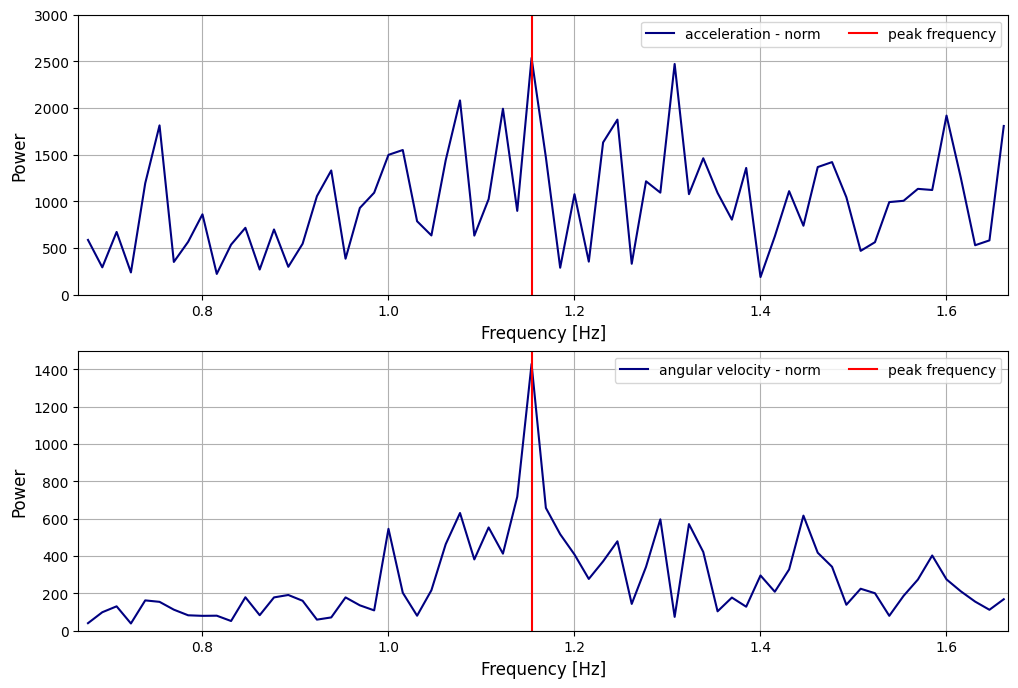

In [70]:
fig7, ax7 = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

ax7[0].plot( acc_freq , acc_power[acc_mask] , '-' , label = 'acceleration - norm' , color = 'navy' )
ax7[0].axvline( acc_peak_freq, color='red' , label = 'peak frequency')
ax7[0].set_xlim( down_freq_lim , up_freq_lim )
ax7[0].set_ylim( 0 , 3000 )
ax7[0].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax7[0].set_ylabel( 'Power' , fontsize = 12 )
#ax7[0].set_yscale('log')
ax7[0].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax7[0].grid()

ax7[1].plot( gyro_freq , gyro_power[gyro_mask] , '-' , label = 'angular velocity - norm' , color = 'navy' )
ax7[1].axvline( gyro_peak_freq , color='red' , label = 'peak frequency')
ax7[1].set_xlim( down_freq_lim , up_freq_lim )
ax7[1].set_ylim( 0 , 1500 )
ax7[1].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax7[1].set_ylabel( 'Power' , fontsize = 12 )
#ax7[1].set_yscale('log')
ax7[1].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax7[1].grid()

plt.show()

In [77]:
acc_filtered_power = acc_power.copy()
acc_filtered_power[ acc_all_freq <= down_freq_lim ] = 0
acc_filtered_power[ acc_all_freq >= up_freq_lim ] = 0

gyro_filtered_power = acc_power.copy()
gyro_filtered_power[ gyro_all_freq <= down_freq_lim ] = 0
gyro_filtered_power[ gyro_all_freq >= up_freq_lim ] = 0

acc_filtered = fftpack.ifft( acc_filtered_power )
gyro_filtered = fftpack.ifft( gyro_filtered_power )

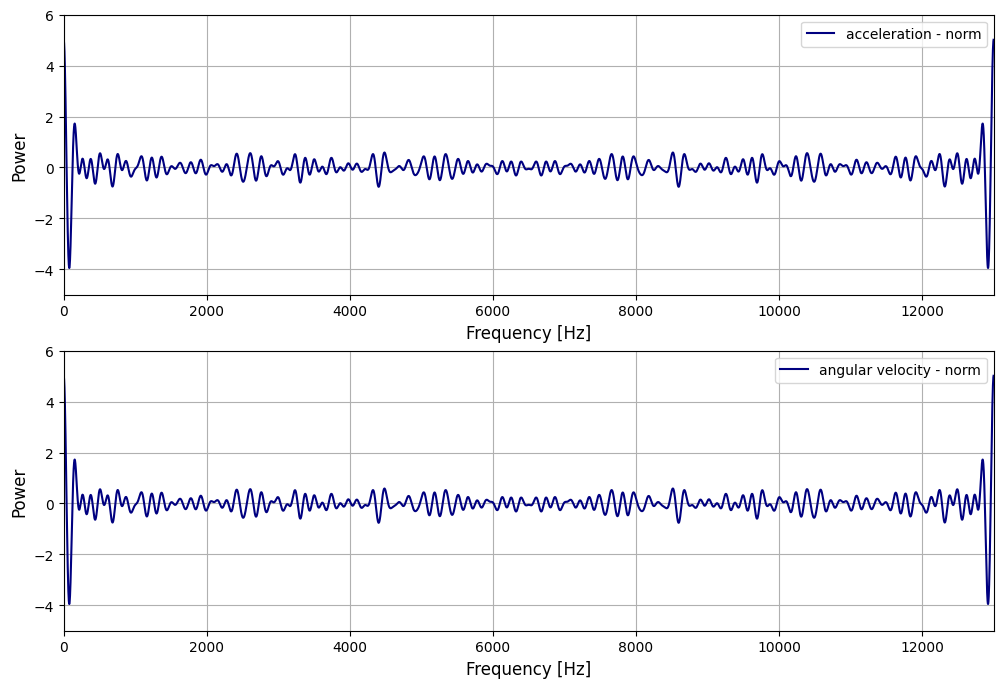

In [87]:
fig8 , ax8 = plt.subplots( nrows=2 , ncols=1 , figsize=(12,8) )

ax8[0].plot( acc_filtered , '-' , label = 'acceleration - norm' , color = 'navy' )
ax8[0].set_xlim( 0 , len(acc_filtered) )
ax8[0].set_ylim( -5 , 6 )
ax8[0].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax8[0].set_ylabel( 'Power' , fontsize = 12 )
ax8[0].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax8[0].grid()

ax8[1].plot( gyro_filtered , '-' , label = 'angular velocity - norm' , color = 'navy' )
ax8[1].set_xlim( 0 , len(gyro_filtered) )
ax8[1].set_ylim( -5 , 6 )
ax8[1].set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax8[1].set_ylabel( 'Power' , fontsize = 12 )
ax8[1].legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax8[1].grid()

plt.show()